In [2]:
source('lib.r')
library(clusterProfiler)
library(msigdbr)
library(dplyr)
library(conos)
library(ggplot2)
library(dplyr)
library(cowplot)

library(devtools)
library(Matrix)
library(dplyr)
library(magrittr)
library(org.Hs.eg.db)
library(edgeR)
library(cacoa)

In [9]:
# read sample groups and conos object


In [8]:
sample.groups = readRDS('sample.group.tumor.rds')
scon = readRDS('tumor.cell_conos.rds')


In [9]:
# Create cacoa object
s.sample.group = sample.group[sample.group %in% c('RCC Primary','RCC Bone Met')]

clu = scon$clusters$leiden$groups %>% Toch()
clu[!is.na(clu)] = 'Tumor'
table(clu)

#table(s.sample.group)
library(cacoa)
target.level <- 'RCC Bone Met'
ref.level <- 'RCC Primary'

cao <- Cacoa$new(scon,
                 sample.groups=as.factor(s.sample.group),
                 cell.groups = as.factor(clu),
                 n.cores=20, target.level=target.level, ref.level=ref.level)

clu
Tumor 
10219 

In [11]:
bs <- if (length(levels(cao$cell.groups)) > 20) 10 else 16
cao$plot.theme <- theme_bw(base_size = bs) + 
  theme(plot.title=element_text(hjust = 0.5), 
        legend.background=element_rect(fill=alpha("white", 0.2)),
        legend.text=element_text(size=12), 
        legend.margin=margin(6, 6, 4, 1, 'pt'),
        plot.margin=margin())

theme_set(cao$plot.theme)

set.seed(239)
cao$cell.groups.palette <- levels(cao$cell.groups) %>% 
  {setNames(sample(brewerPalette("Paired")(length(.))), .)}

cao$sample.groups.palette <- c("#d73027", "#4575b4") %>% 
  setNames(c(cao$target.level, cao$ref.level))



In [ ]:
# estimate DE genes Per CellType

In [8]:
mean(table(cao$sample.per.cell) )
# average number of tumor cells 

[1] 319.3438

In [12]:
cao$estimateDEPerCellType(independent.filtering=TRUE, test='DESeq2.Wald',min.cell.frac=0.01,
                          n.resamplings=100,min.cell.count = 10,resampling.method ='loo',n.cells.subsample = 320)


In [13]:
cao$test.results$de$Tumor$res[1:4,]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Gene,Z,Za,stab.median.rank,stab.mean.rank,stab.var.rank,CellFrac,SampleFrac
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
SAA1,178.16042,9.357688,1.2031688,7.777535,7.395107e-15,8.569450e-11,SAA1,7.777535,6.490249,1,1.1875,0.162500,0.09981407,0.6250
MTRNR2L1,135.42028,4.100840,0.5735303,7.150172,8.666943e-13,5.021627e-09,MTRNR2L1,7.150172,5.846454,2,2.1875,0.562500,0.29875722,1.0000
SAA2,26.84967,8.137080,1.2299219,6.615932,3.692177e-11,1.426165e-07,SAA2,6.615932,5.261846,4,5.2500,7.666667,0.03845777,0.4375
PON2,41.63150,2.311198,0.3561763,6.488915,8.645689e-11,2.504656e-07,PON2,6.488915,5.157353,5,5.2500,2.066667,0.19424601,1.0000


In [14]:
de.tab=cao$test.results$de$Tumor$res


In [15]:
dot.fig = function(res,genes,col.up,col.down){
# create custom key-value pairs for 'high', 'low', 'mid' expression by fold-change
  # this can be achieved with nested ifelse statements
  keyvals <- ifelse(
    res$log2FoldChange <= -1.5 & res$padj < 0.01, col.down,
      ifelse(res$log2FoldChange >= 1.5 & res$padj < 0.01, col.up,
        'black'))


  keyvals[is.na(keyvals)] <- 'black'
  names(keyvals)[keyvals == col.up] <- 'high'
  names(keyvals)[keyvals == 'black'] <- 'mid'
  names(keyvals)[keyvals == col.down] <- 'low'
  
  
  keyvalssize = keyvals
   keyvalssize[keyvalssize == col.up] <- 1
  keyvalssize[keyvalssize == 'black'] <- 3
  keyvalssize[keyvalssize == col.down] <- 3
  keyvalssize = as.numeric(keyvalssize)
  
  
  keyvalssize <- ifelse(
    res$log2FoldChange <= -1.5 & res$padj < 0.01, 3,
      ifelse(res$log2FoldChange >= 1.5 & res$padj < 0.01, 3,
        1))
  
  
 fig=EnhancedVolcano(res,
    lab = rownames(res),
    x = 'log2FoldChange',
    y = 'padj',
    title=NULL,
    subtitle=NULL, 
    caption=NULL,
    selectLab = c(rownames(res)[which(names(keyvals) %in% c('high', 'low'))][1:5],genes),
    xlab = bquote(~Log[2]~ 'fold change'),
    ylab = bquote(~Log[10]~ 'padj'),
    pCutoff = 0.01,
    FCcutoff = 1.5,
    pointSize = keyvalssize, #3.5,
    labSize = 4.5,
    #shape = c(6, 4, 2, 11),
    colCustom = keyvals,
    colAlpha = 1,
    legendPosition = 'none',
    legendLabSize = 15,
    legendIconSize = 5.0,
    drawConnectors = TRUE,
    widthConnectors = 1.0,
    colConnectors = 'black',
    arrowheads = FALSE,
    gridlines.major = TRUE,
    gridlines.minor = FALSE,
    border = 'partial',
    borderWidth = 1.5,
    borderColour = 'black')
 
 return(fig)
    }

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


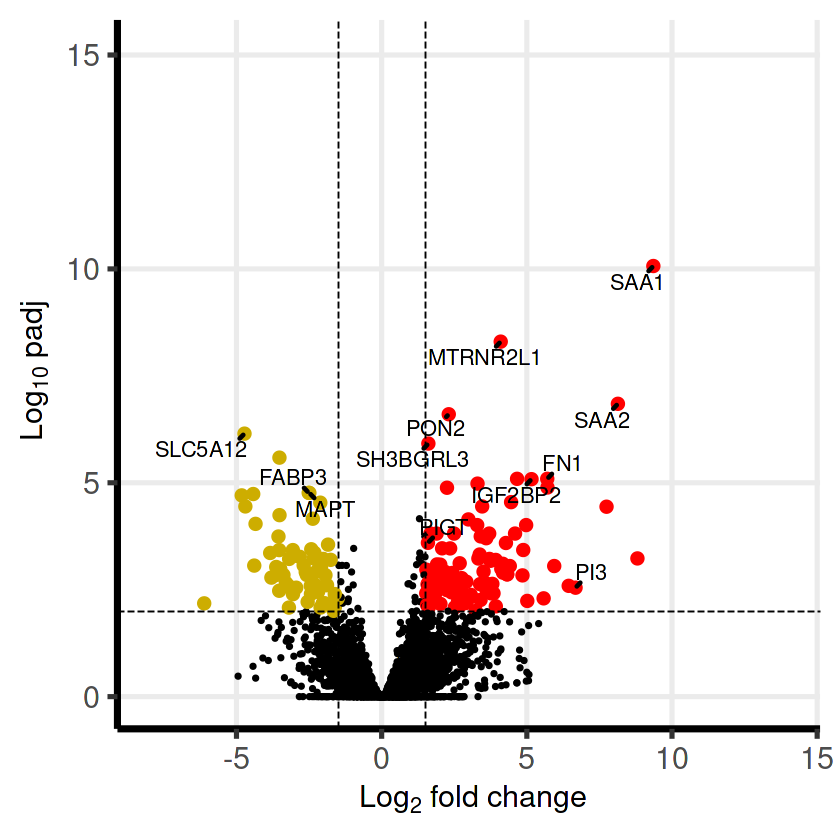

In [16]:
de.tab = de.tab[order(de.tab$Z,decreasing=T),]

res=de.tab
genes = c('SH3BGRL3','FN1','IGF2BP2','PIGT','MET','SLC5A12','PI3','FABP3','MAPT')
library(EnhancedVolcano)
col.up = fraction.palette2['RCC Bone Met']
col.down = fraction.palette2['RCC Primary']
p=dot.fig(res,genes,col.up,col.down)+xlim(c(-8,14))
p

In [17]:
ggsave('volcano.plot.pdf',p,height=4.3,width=5.2)


In [18]:
go.environment = readRDS('go.environment.rds')

getGO = function(cao,de.gene,gene_universe,go.environment ){
    org.db <- org.Hs.eg.db::org.Hs.eg.db
    gene_universe_ids <- cacoa:::mapGeneIds(gene_universe, org.db)
    gene_back_map <- setNames(names(gene_universe_ids), gene_universe_ids)
    de.gene.ids = lapply(de.gene,function(x) cacoa:::mapGeneIds(x, org.db))
    res <- cacoa:::estimateEnrichedGO(de.gene.ids, org.db=org.db, go.environment=go.environment, universe=gene_universe_ids)

    num=sapply(res$BP, function(r) sum(r@result$p.adjust < 0.1)) %>% setNames(1:length(.))
    print(num)
    return(res)
}

[1] "SAA1"     "SAA2"     "PON2"     "SH3BGRL3"

[1] "ZFP36"  "RBFOX3" "NFKBIA" "SKIL"   "DUSP6"

 1 
81 


1 
38

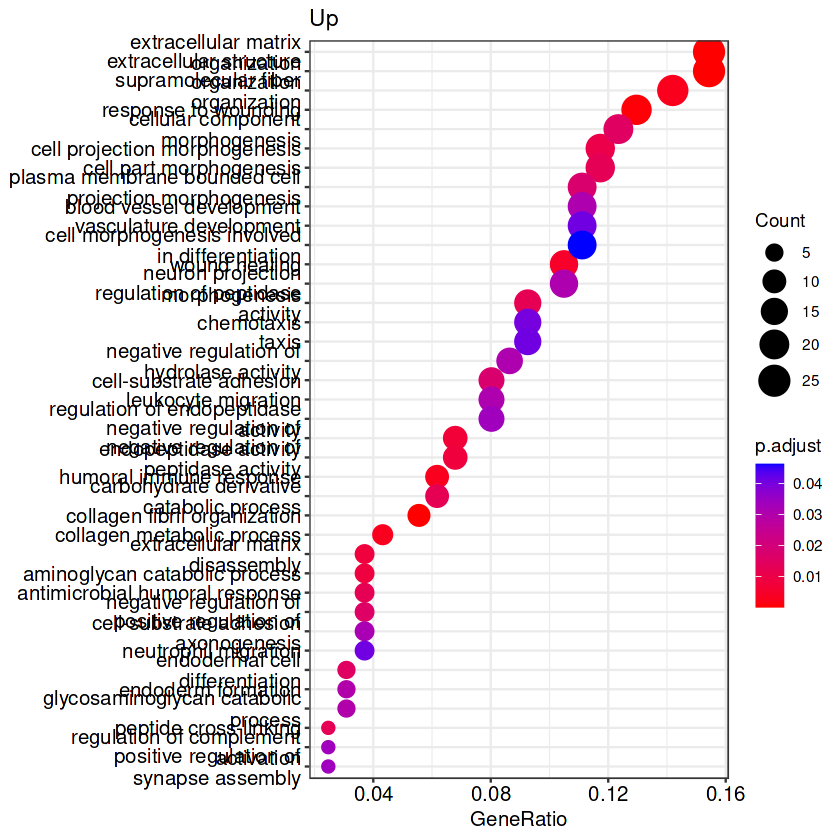

In [20]:
de.tab = de.tab[!grepl('^MTR|^MT-',de.tab$Gene),]

gene_universe <- rownames(de.tab)

de.tab = de.tab[de.tab$log2FoldChange >1.5 & de.tab$padj < 0.05 ,]
gs=rownames(de.tab)
org.db <- org.Hs.eg.db::org.Hs.eg.db



de.gene = list('Up'=gs)
gs[1:4]
gs.down[1:5]

res = getGO(cao,de.gene,gene_universe,go.environment)  
sapply(res$BP, function(r) sum(r@result$p.adjust < 0.05)) %>% setNames(1:length(.))
for (i in names(res$BP)) {
  p <- clusterProfiler::dotplot(res$BP[[i]], showCategory=40, title=i)
  print(p)
}


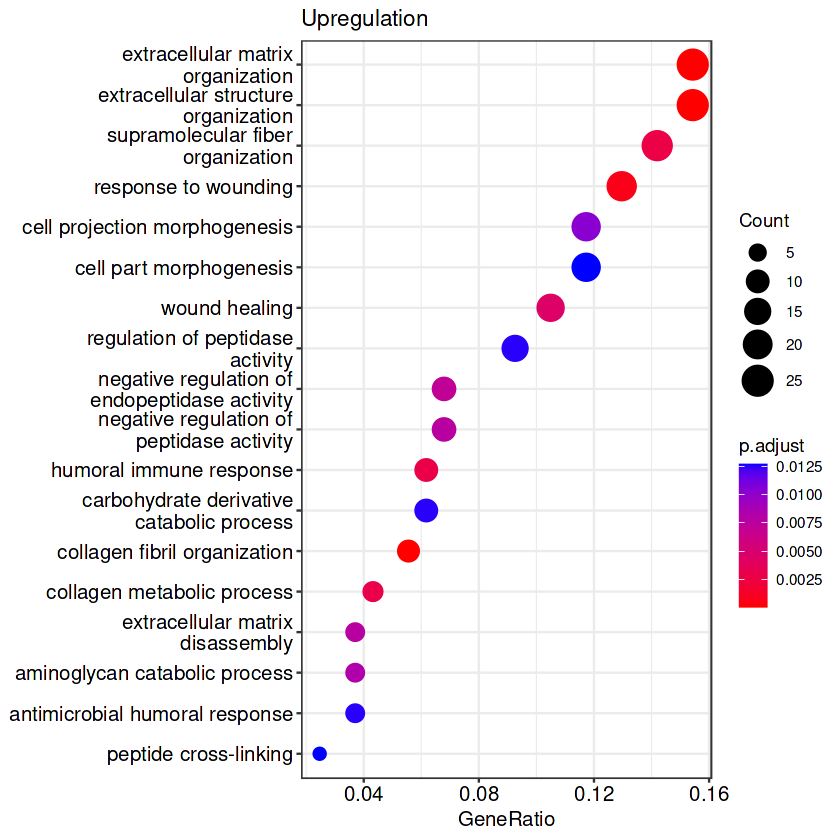

In [26]:
p <- clusterProfiler::dotplot(res$BP[['Up']], showCategory=18, title='Upregulation')
p
ggsave('GO.upregulation.pdf',p,height=6.6,width=6.8)
